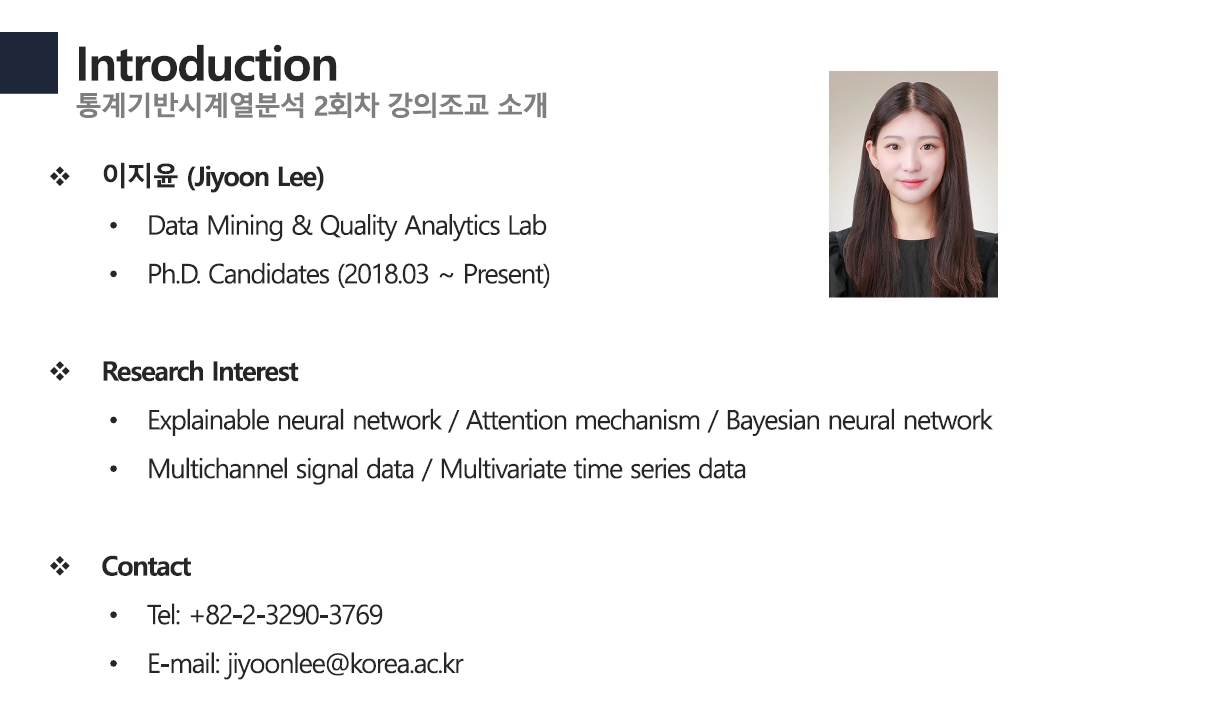

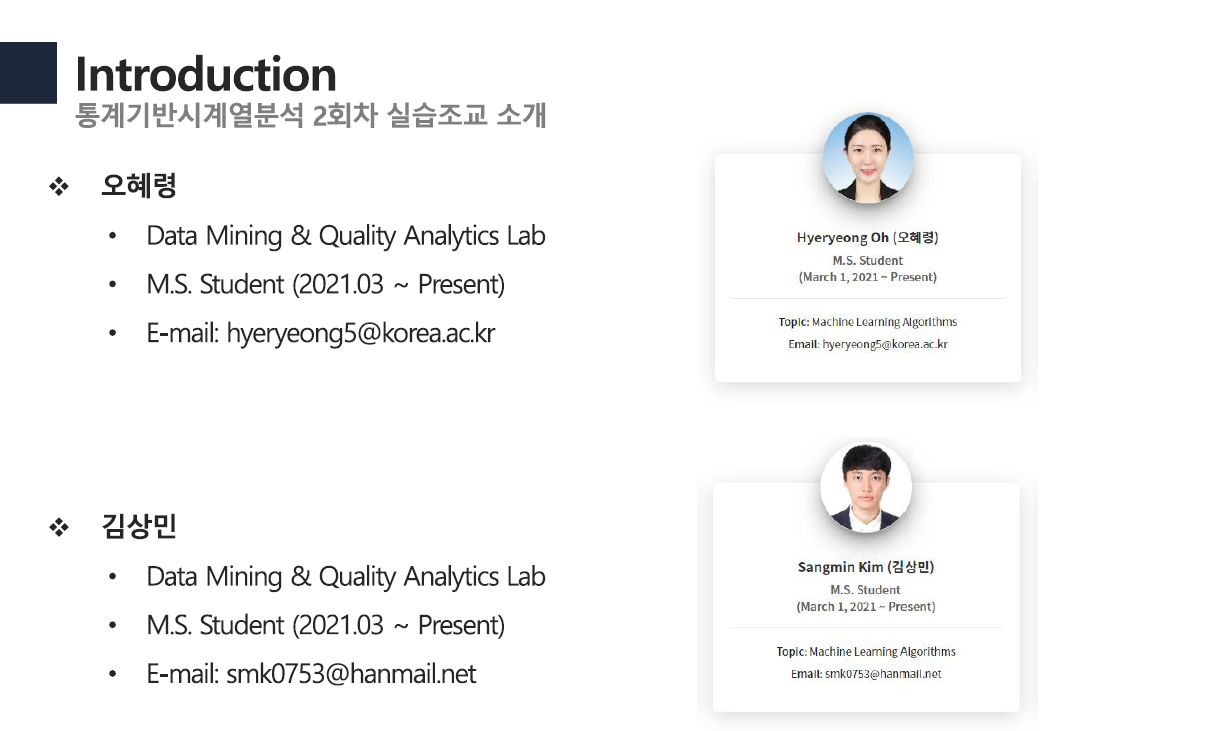

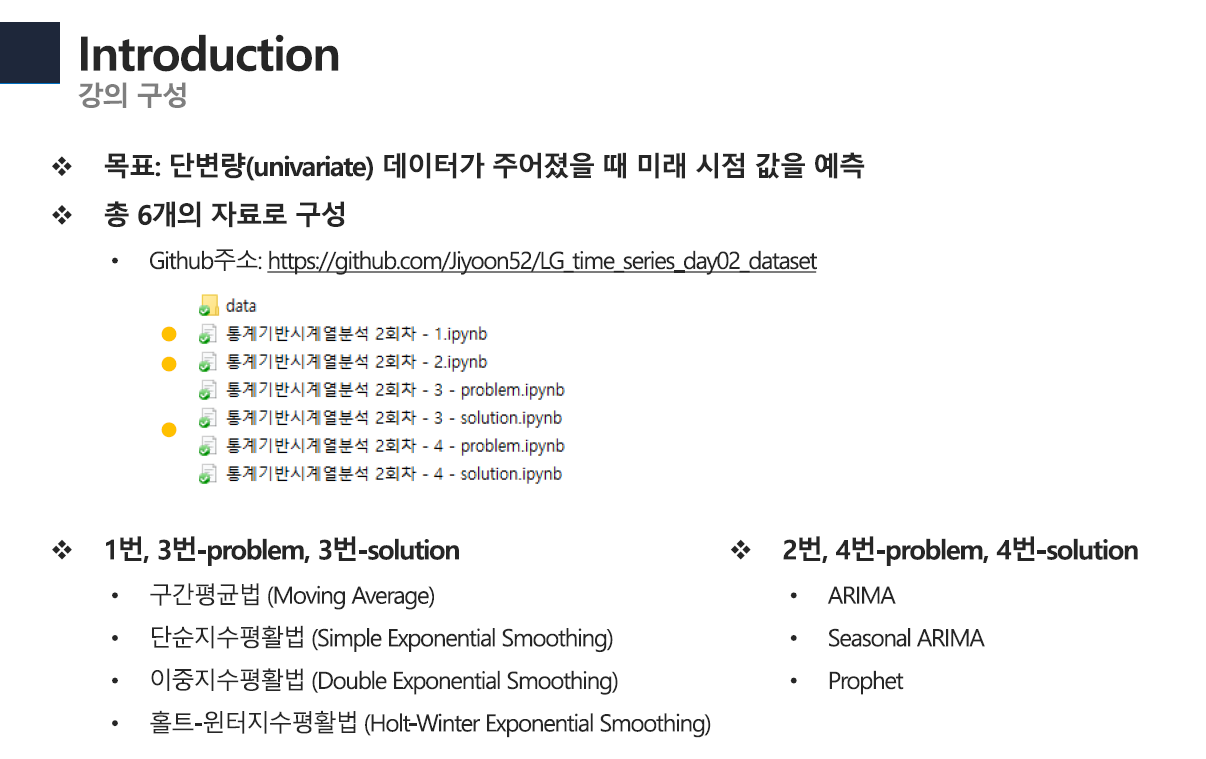

# [예측모델] 

## - 구간평균법 
## - 단순지수평활법 
## - 이중지수평활법 
## - 홀트-윈터지수평활법 

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

### 1. 모듈 불러오기

In [ ]:
# !git clone https://github.com/Jiyoon52/LG_time_series_day02_dataset.git

In [ ]:
import os

import pandas as pd
import pandas_datareader.data as pdr

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

from sklearn.datasets import fetch_openml
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import seaborn as sns
#sns.set_style("white")

import itertools
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 

### 2. 데이터 불러오기

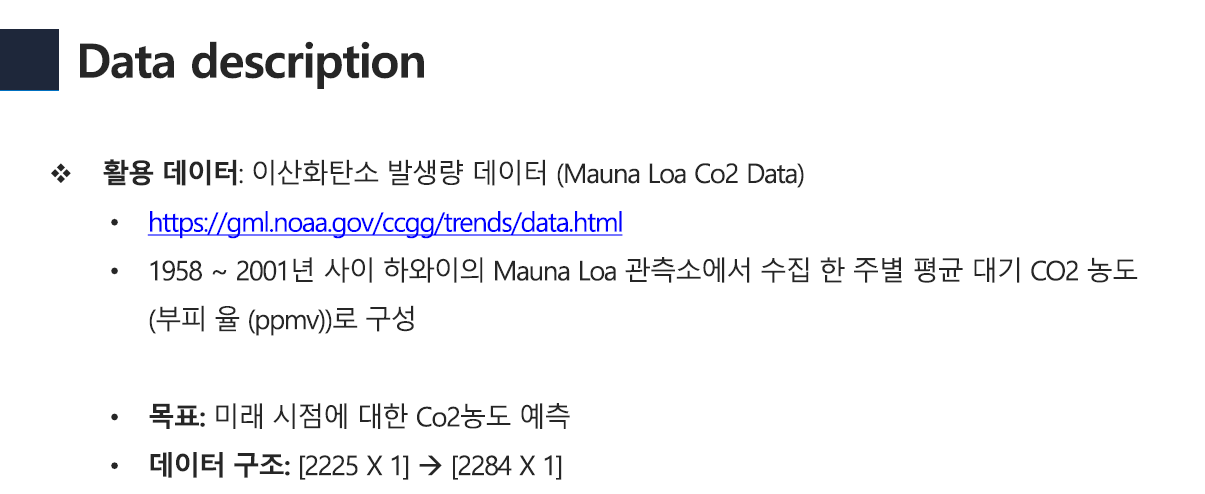

In [ ]:
co2_data = pd.read_csv('data/co2.csv')
# co2_data = pd.read_csv('/content/LG_time_series_day02_dataset/data/co2.csv')

#### 2.1 Data Preprocessing

In [ ]:
'''
년/월/일 병합하여 'data' 변수 생성
'''
co2_data['date'] = pd.to_datetime(co2_data[['year', 'month', 'day']]) # 데이터를 날짜정보로 인식하고 병합된 형태로 변환
data = co2_data[['date', 'co2']].set_index('date') # date 변수를 index로 변환

In [ ]:
data.head() # 상위 5개

In [ ]:
data.tail() # 하위 5개

In [ ]:
data.shape # 데이터 차원 확인

In [ ]:
data.describe() # 데이터 통계값 확인

In [ ]:
data.index # 데이터 인덱스(순서정보) 확인

In [ ]:
'''
s: 초
T: 분
H: 시간
D: 일(day)
B: 주말이 아닌 평일
W: 주(일요일)
W-MON: 주(월요일)
M: 각 달(month)의 마지막 날
MS: 각 달의 첫날
BM: 주말이 아닌 평일 중에서 각 달의 마지막 날
BMS: 주말이 아닌 평일 중에서 각 달의 첫날
WOM-2THU: 각 달의 두번째 목요일
Q-JAN: 각 분기의 첫달의 마지막 날
Q-DEC: 각 분기의 마지막 달의 마지막 날
'''

data = data.asfreq('W-SAT') # 주(토요일)
data.index

In [ ]:
data.info() # 전체 데이터 개요 및 결측치 정보 확인

In [ ]:
data.isnull().sum() # 결측값(빈값, Nan, Null) 수 확인

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
# https://rfriend.tistory.com/262
data = data.fillna(data.bfill()) # 결측값 바로 뒤 값으로 대체 (fill values backward) 
# data = data.fillna(data.ffill()) # 결측값 바로 앞 값으로 대체 (fill values forward) 

data.isnull().sum()

In [ ]:
data.shape # 데이터 차원 확인 (날짜 및 결측치 처리 후)

In [ ]:
'''
데이터 시각화를 통해 전체 개요 확인
'''
data.plot(figsize=(12,4)) # color='green', linestyle='--', linewidth=1

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend('')

plt.title('Raw air samples measurements from the Mauna Loa Observatory \n', fontsize=15)
plt.xlabel('\n Year', fontsize=13)
plt.ylabel('Co2 \n', fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
# Seasonal decomposition plot: Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

# Observed: observed data
# Trend: The estimated trend component
# Seasonal: The estimated seasonal component
# resid: The estimated residuals

decompostion = sm.tsa.seasonal_decompose(data['co2'],  model='additive')

fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

In [ ]:
'''
Train Test Split (날짜를 기준으로 분할하여)
'''
train = data[:'1989-12']
test  = data['1990-01':]

### 3. Moving Average (구간평균법)

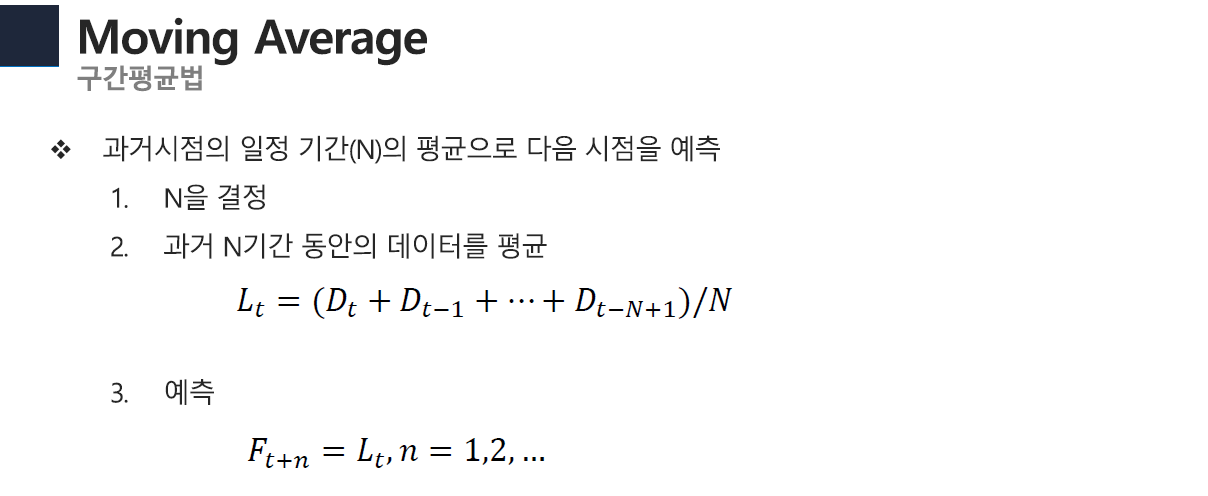

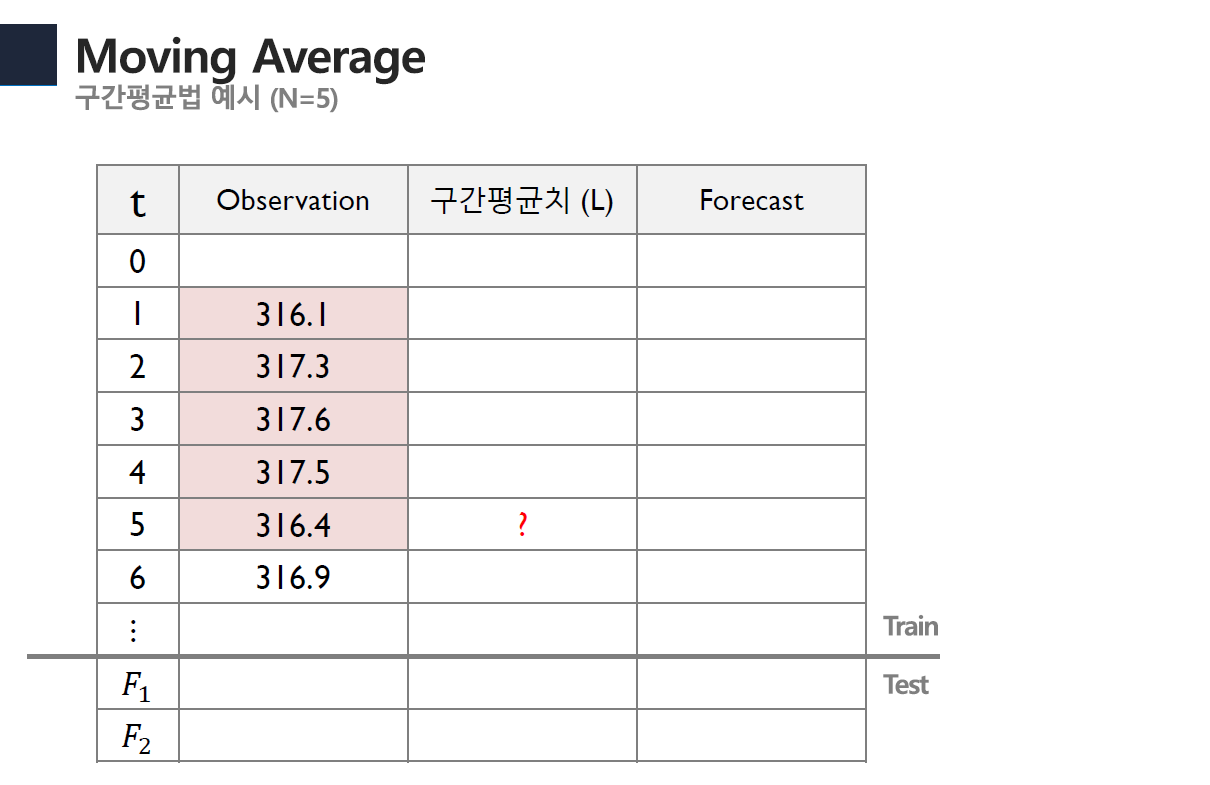

In [ ]:
'''
Version 1

직접 재현해보기
'''
def Moving_Average(x, N):
    x = x.values.flatten()
    
    pred = np.convolve(x, np.ones(N) / float(N), 'valid')
    pred = np.concatenate((np.zeros(N-1), pred), axis=0)
    pred[:N-1] = np.nan
    return pred

MA_train_pred = pd.DataFrame(Moving_Average(train, 5), index=train.index, columns=['MA_5'])
MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])

print('Moving Average Train results')
print(MA_train_pred)
print('-'*30)
print('Moving Average Test results')
print(MA_test_pred)

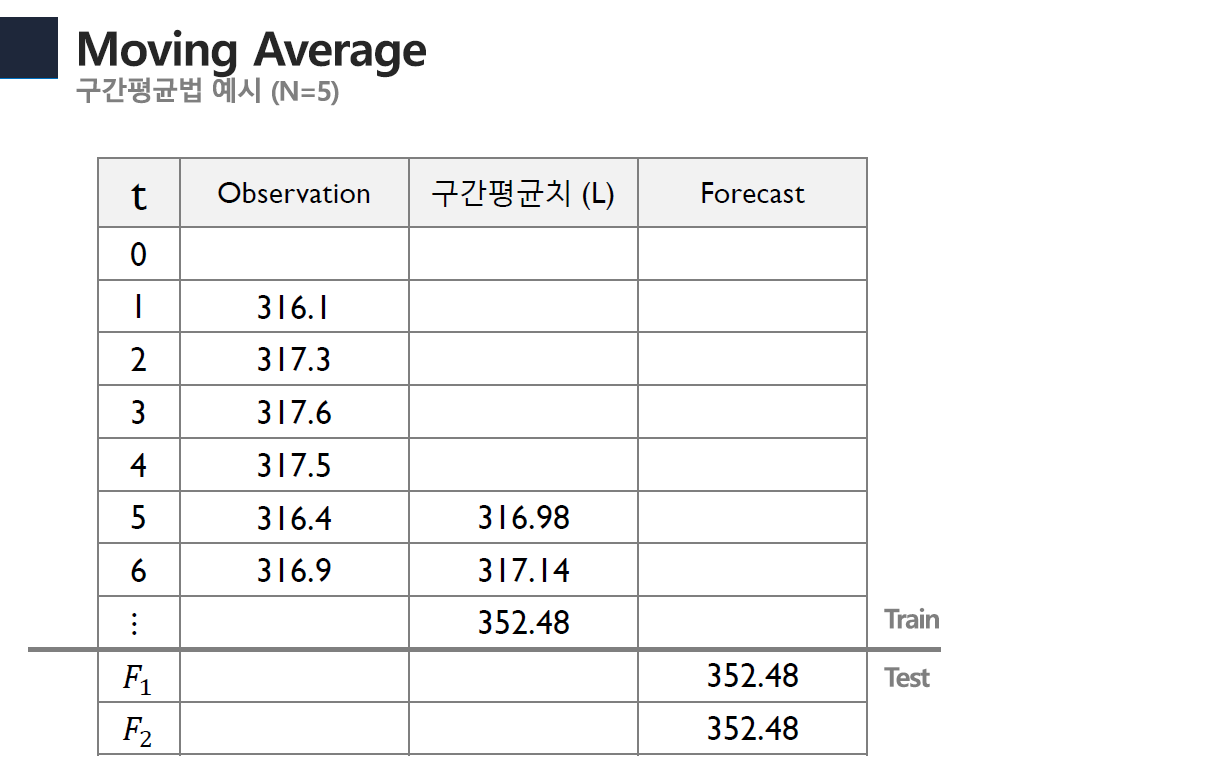

In [ ]:
'''
Version 2 

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
'''

MA_train_pred = train.rolling(5).mean() # Option: min_periods=1 
MA_train_pred.columns = ['MA_5']

MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])
prediction = pd.concat([MA_train_pred, MA_test_pred], axis=0)

print('Moving Average Train Results')
print(MA_train_pred)
print('-'*30)
print('Moving Average Test Results')
print(MA_test_pred)

In [ ]:
'''
Visualization 
'''
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
prediction.plot(ax=ax, label = 'Prediction (N=5)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (N=5)', 'Start of Forecast'], loc='upper left')
plt.title('Moving Average Results (Train and Test)')
plt.tight_layout()
plt.show()

# Only Test
# fig, ax = plt.subplots(figsize=(12,4))
# data.plot(ax=ax)
# MA_test_pred.plot(ax=ax, label = 'Prediction (N=5)')
# ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
# ax.legend(['Raw Dataset', 'Prediction (N=5)', 'Start of Forecast'], loc='upper left')
# plt.title('Moving Average Results (Only Test)')
# plt.tight_layout()
# plt.show()

##### 정량적 지표를 통한 모델 검증

###### Mean Squared Error (평균 제곱 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$   

In [ ]:
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')

######  Root Mean Squared Error (제곱근 평균 제곱 오차) <br>
$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}}$

In [ ]:
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')

##### Mean Absolute Error (평균 절대 오차) <br>
$\frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$

In [ ]:
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')

#####  R squared (결정계수 $({r})^{2}$) <br>
$\frac{SSR}{SST} = 1- \frac{SSR}{SST}%$

In [ ]:
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

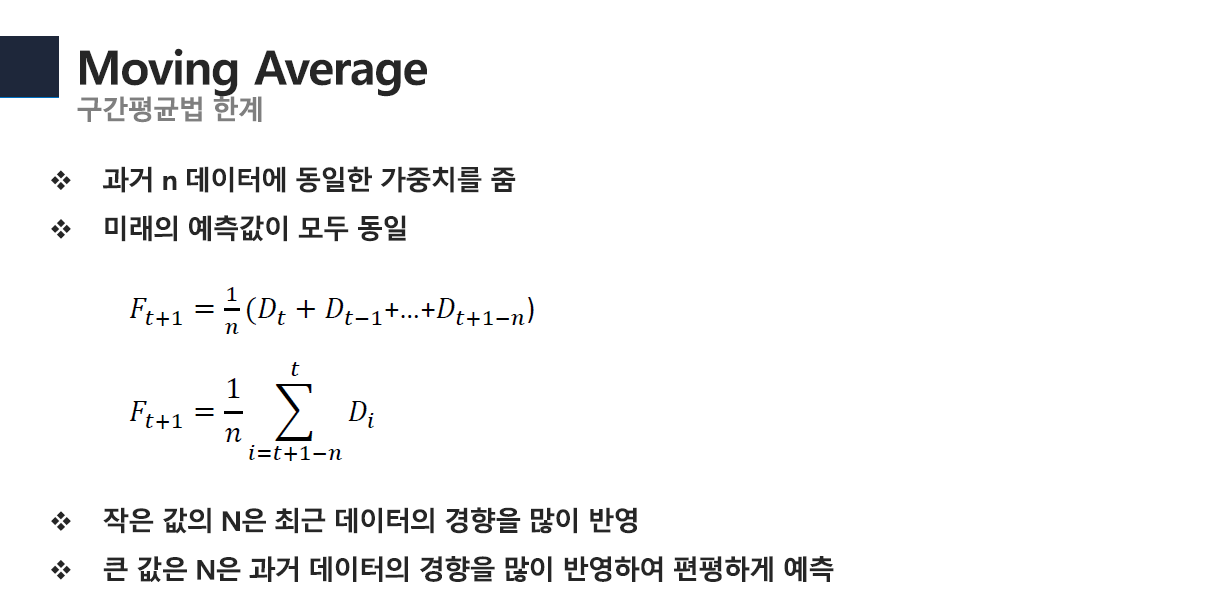

### 4. Exponential Smoothing (지수평활법)

#### 4.1 Simple Exponential Smoothing (단순지수평활법)

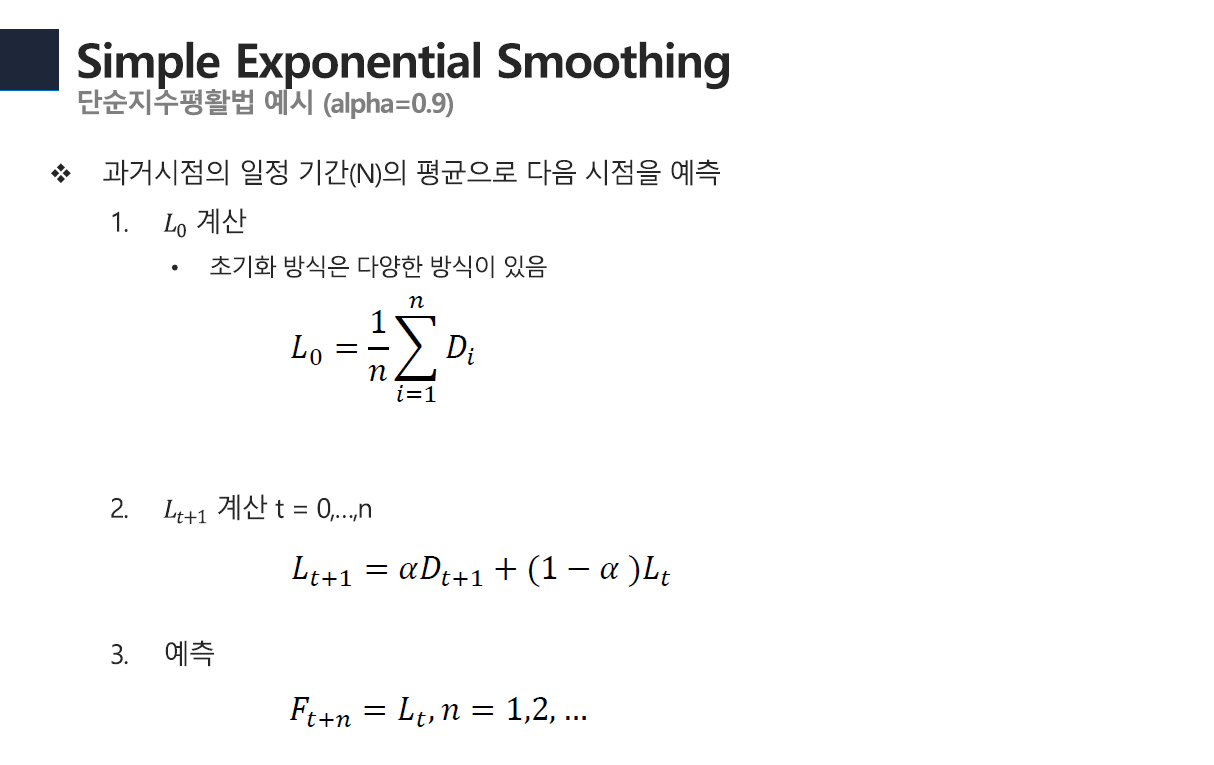

In [ ]:
# 초기 테이블 생성
L_0 = np.mean(train)  # initial value (L0계산)

SES_train = train.copy()
SES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['co2']), SES_train])
SES_train['Level'] = np.nan
SES_train['Forecast'] = np.nan
SES_train.loc[0,'Level'] = L_0.values

SES_train

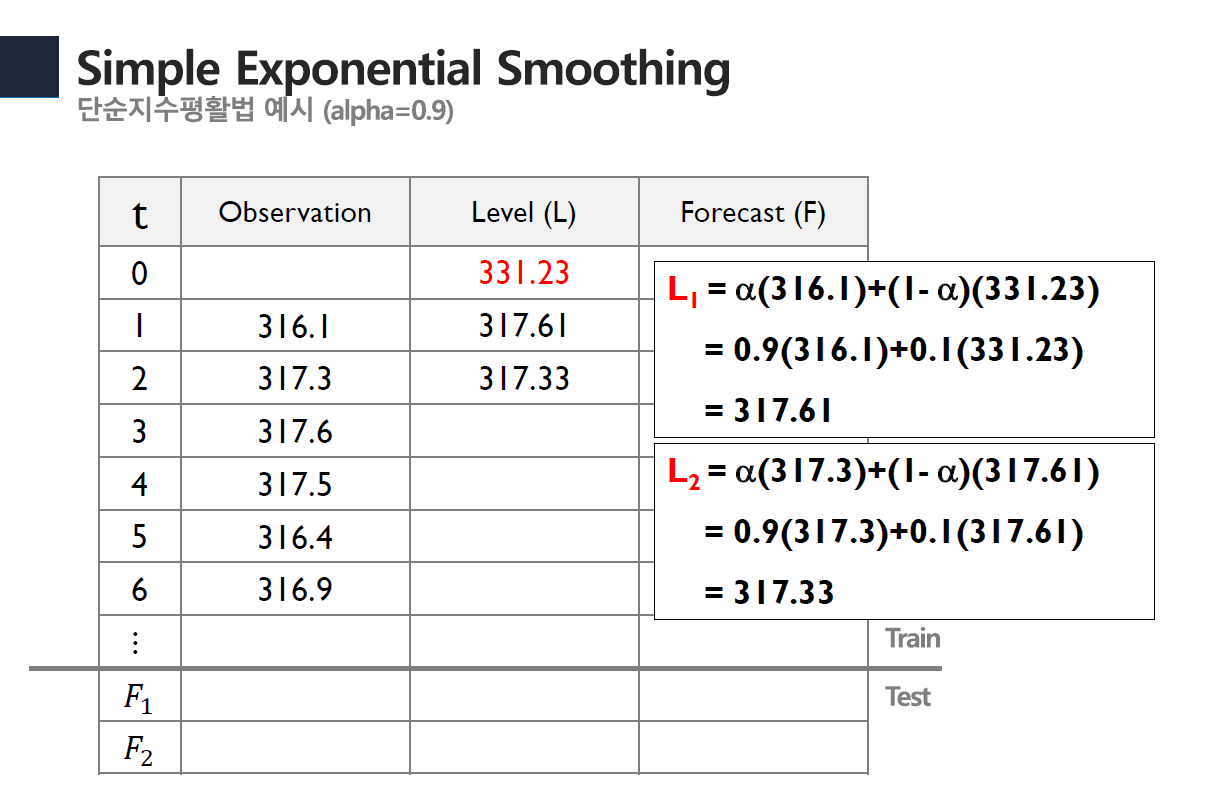

In [ ]:
'''
Version 1
'''
def Simple_Exponential_Smoothing(table, alpha):
    # table = SES_train.copy()
    # alpha = 0.9
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'co2'] # 316.1
        L_prev = table.loc[list(table.index)[i-1],'Level'] # 331.23
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev)

    L_pred = table.iloc[-1,1]
    SES_test_pred = [L_pred]*len(test)
    SES_test_pred = pd.DataFrame(SES_test_pred, index=test.index, columns=[f'SES_{alpha}'])
        
    return table, SES_test_pred

In [ ]:
SES_train_pred, SES_test_pred = Simple_Exponential_Smoothing(SES_train, 0.9)

In [ ]:
print('Simple Exponential Smoothing Train Results')
print(SES_train_pred)
print('-'*30)
print('Simple Exponential Smoothing Test results')
print(SES_test_pred)

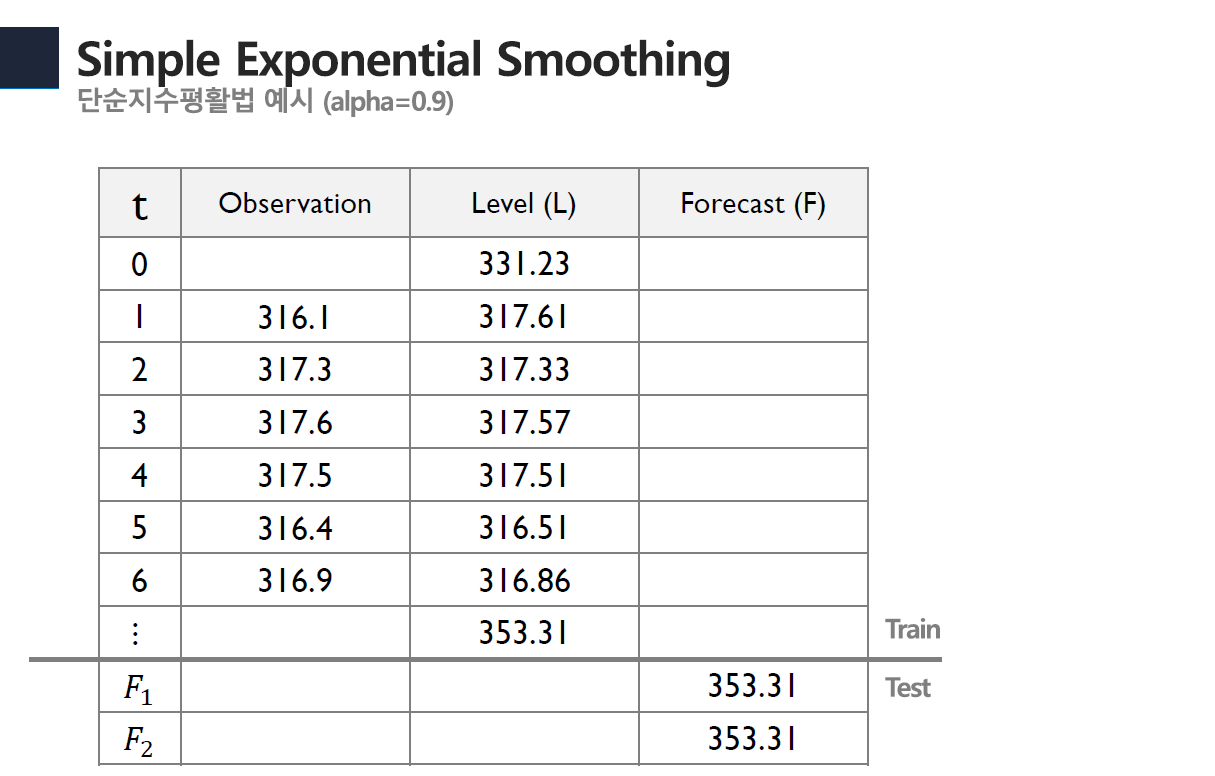

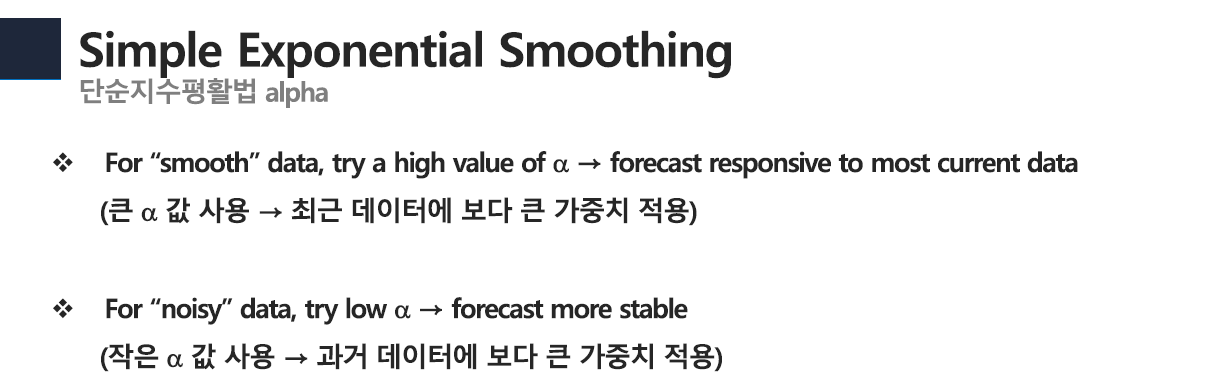

In [ ]:
'''
Version 2

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
'''
# adjust를 통해 초기값을 설정할 수 있음
# 교육자료와 통일시키기 위해 초기값(L_0)은 평균값을 활용하는 임의의 코드를 구성
SES_train_pred_09 = pd.concat([pd.DataFrame([L_0], columns=['co2']), train]).ewm(alpha=0.9, adjust=False).mean().iloc[1:]
SES_train_pred_09.columns = ['SES_09']
SES_test_pred_09 = pd.DataFrame(np.array([SES_train_pred_09.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_09'])
prediction_09 = pd.concat([SES_train_pred_09, SES_test_pred_09], axis=0)

SES_train_pred_05 = pd.concat([pd.DataFrame([L_0], columns=['co2']), train]).ewm(alpha=0.5, adjust=False).mean().iloc[1:]
SES_train_pred_05.columns = ['SES_05']
SES_test_pred_05 = pd.DataFrame(np.array([SES_train_pred_05.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_05'])
prediction_05 = pd.concat([SES_train_pred_05, SES_test_pred_05], axis=0)

SES_train_pred_01 = pd.concat([pd.DataFrame([L_0], columns=['co2']), train]).ewm(alpha=0.1, adjust=False).mean().iloc[1:]
SES_train_pred_01.columns = ['SES_01']
SES_test_pred_01 = pd.DataFrame(np.array([SES_train_pred_01.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_01'])
prediction_01 = pd.concat([SES_train_pred_01, SES_test_pred_01], axis=0)

In [ ]:
'''
Visualization 
'''
fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
prediction_09.plot(ax=ax, label = 'Prediction (alpha=0.9)')
prediction_05.plot(ax=ax, label = 'Prediction (alpha=0.5)')
prediction_01.plot(ax=ax, label = 'Prediction (alpha=0.1)')

ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (alpha=0.9)', 'Prediction (alpha=0.5)', 'Prediction (alpha=0.1)', 'Start of Forecast'], loc='upper left')
plt.title('Exponential Moving Average Results')
plt.tight_layout()
plt.show()

# Only Test (일부 시점만 확대해서 그려보자!)
fig, ax = plt.subplots(figsize=(12,4))
data['1989-06':'1990-06'].plot(ax=ax)
prediction_09['1989-06':'1990-06'].plot(ax=ax, label = 'Prediction (alpha=0.9)')
prediction_05['1989-06':'1990-06'].plot(ax=ax, label = 'Prediction (alpha=0.5)')
prediction_01['1989-06':'1990-06'].plot(ax=ax, label = 'Prediction (alpha=0.1)')

ax.vlines(test.index[0], 349, 358, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'Prediction (alpha=0.9)', 'Prediction (alpha=0.5)', 'Prediction (alpha=0.1)', 'Start of Forecast'], loc='upper left')
plt.title('Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [ ]:
'''
Quantitative Evaluation
'''
print('-'*30)
print('alpha  = 0.9')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_09), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_09)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_09), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_09), 2)}')

print('-'*30)
print('alpha  = 0.5')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_05), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_05)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_05), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_05), 2)}')

print('-'*30)
print('alpha  = 0.1')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_01), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_01)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_01), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_01), 2)}')

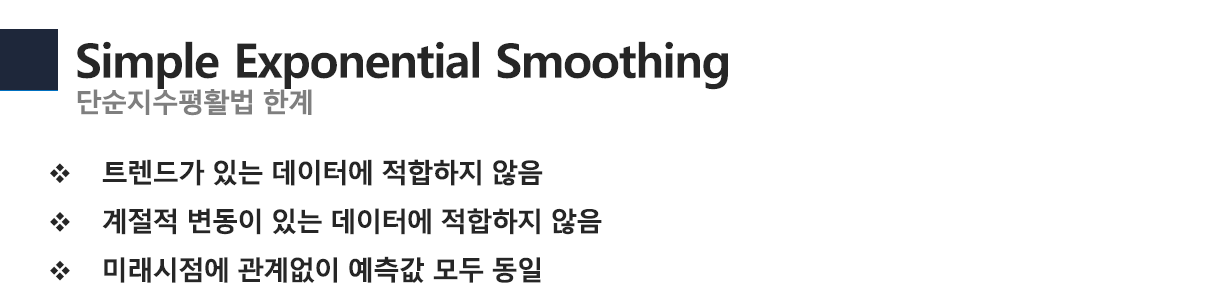

#### 4.2 Double Exponential Smoothing (이중지수평활법)

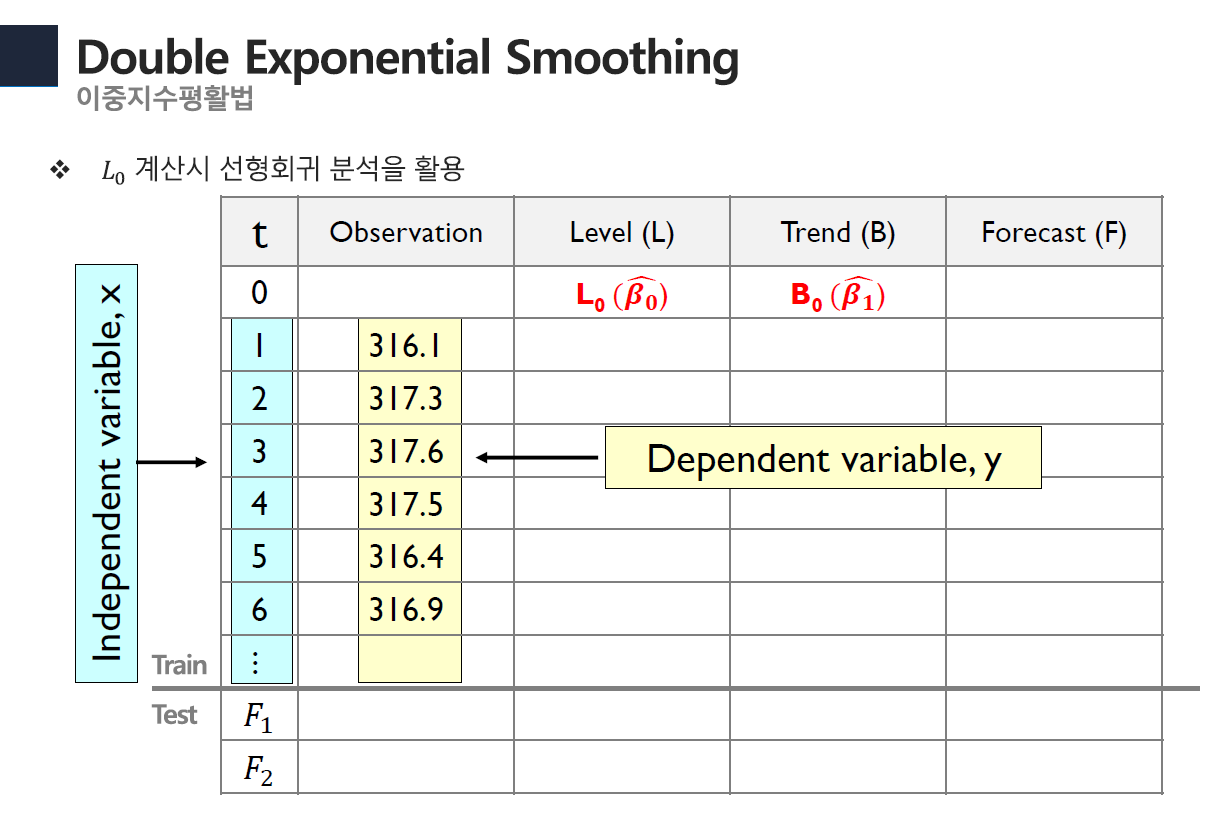

In [ ]:
'''
Searching Initialization Points

초기값을 선형회귀를 활용하여 정의, 차주 선형회귀 강의에서 자세히 다룰 예정
'''
train_reg = train.reset_index()
x = np.array(train_reg.index)
y = train_reg['co2']

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()

print(results.summary())
L_0, B_0 = results.params

In [ ]:
# 초기 테이블 구성
DES_train = train.copy()
DES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['co2']), DES_train])
DES_train['Level'] = np.nan
DES_train['Trend'] = np.nan
DES_train['Forecast'] = np.nan

DES_train.loc[0,'Level'] = L_0
DES_train.loc[0,'Trend'] = B_0

DES_train

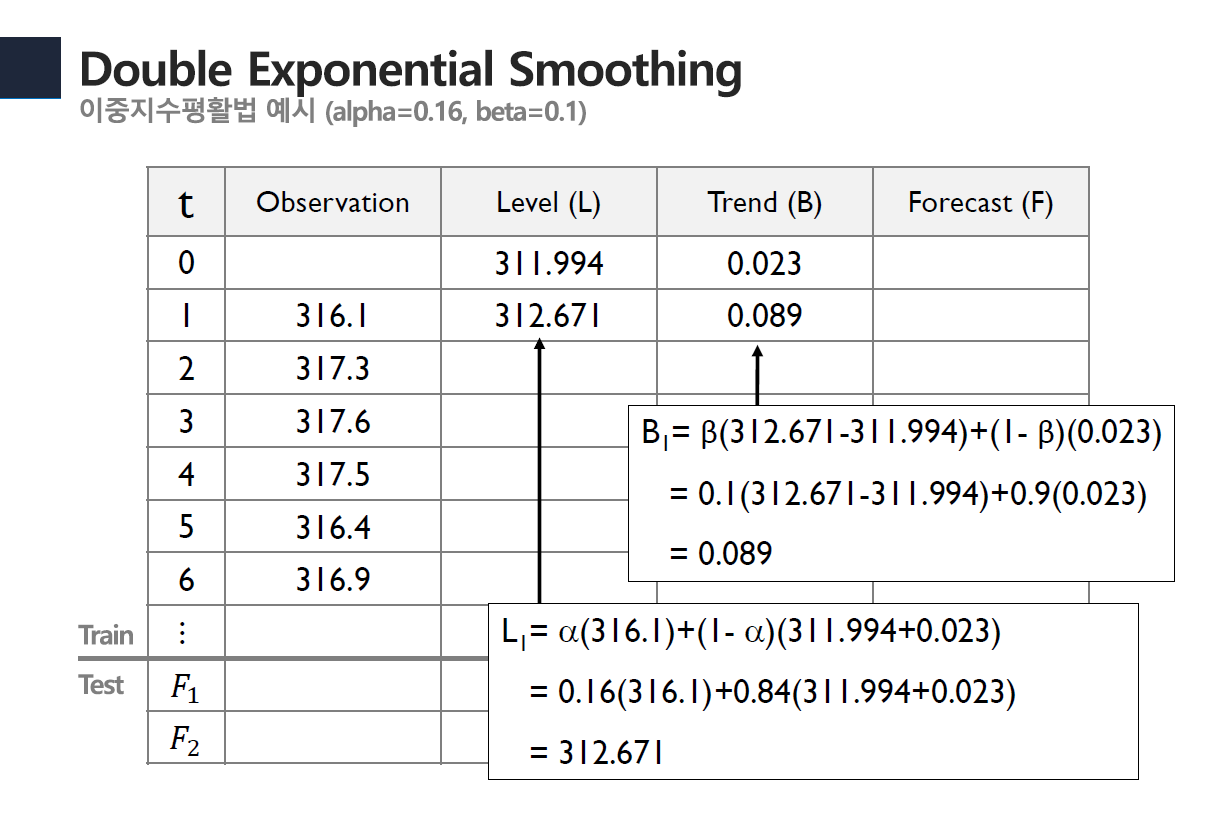

In [ ]:
def Double_Exponential_Smoothing(table, alpha, beta):
    # table = DES_train.copy()
    # alpha = 0.16
    # beta = 0.1
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'co2'] # 316.1
        L_prev = table.loc[list(table.index)[i-1],'Level'] # 311.994
        T_prev = table.loc[list(table.index)[i-1],'Trend'] # 0.023
        
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev+T_prev)
        table.loc[list(table.index)[i],'Trend'] = beta*(table.loc[list(table.index)[i],'Level']-L_prev) + (1-beta)*(T_prev)

    L_Pred = table.iloc[-1,1]
    T_Pred = table.iloc[-1,2]

    DES_test_pred = L_Pred + range(1,len(test)+1)*T_Pred
    DES_test_pred = pd.DataFrame(DES_test_pred, index = test.index, columns=['DES'])
        
    return table, DES_test_pred

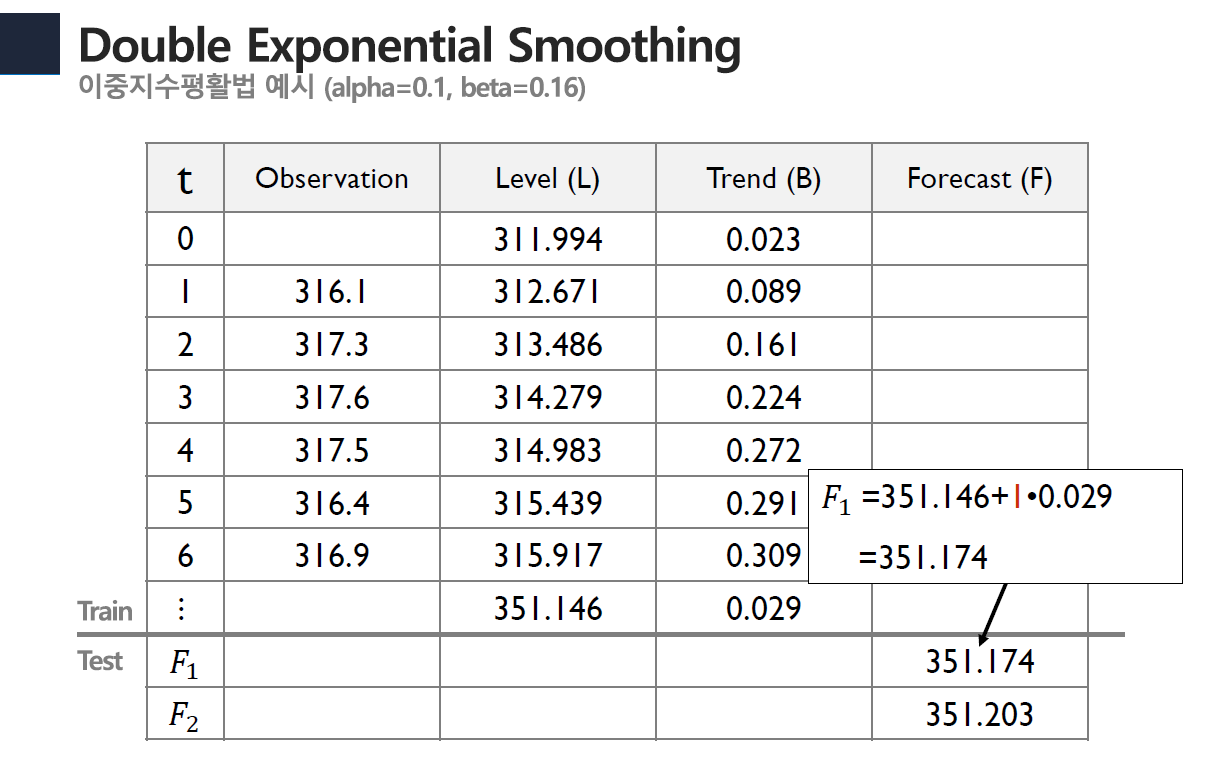

In [ ]:
DES_train_pred, DES_test_pred = Double_Exponential_Smoothing(DES_train, 0.16, 0.1)

In [ ]:
print('Double Exponential Smoothing Train Results')
print(DES_train_pred)
print('-'*30)
print('Double Exponential Smoothing Test results')
print(DES_test_pred)

In [ ]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(DES_train_pred.iloc[1:,1])
train_pred.columns = ['DES']
DES_pred = pd.concat([train_pred, DES_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
DES_pred.plot(ax=ax, label = 'Prediction (alpha=0.16, beta=0.1)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'DEMA (alpha=0.16, beta=0.1)', 'Start of Forecast'], loc='upper left')
plt.title('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [ ]:
'''
Quantitative Evaluation
'''
print('-'*30)
print('alpha  = 0.16, beta = 0.1')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

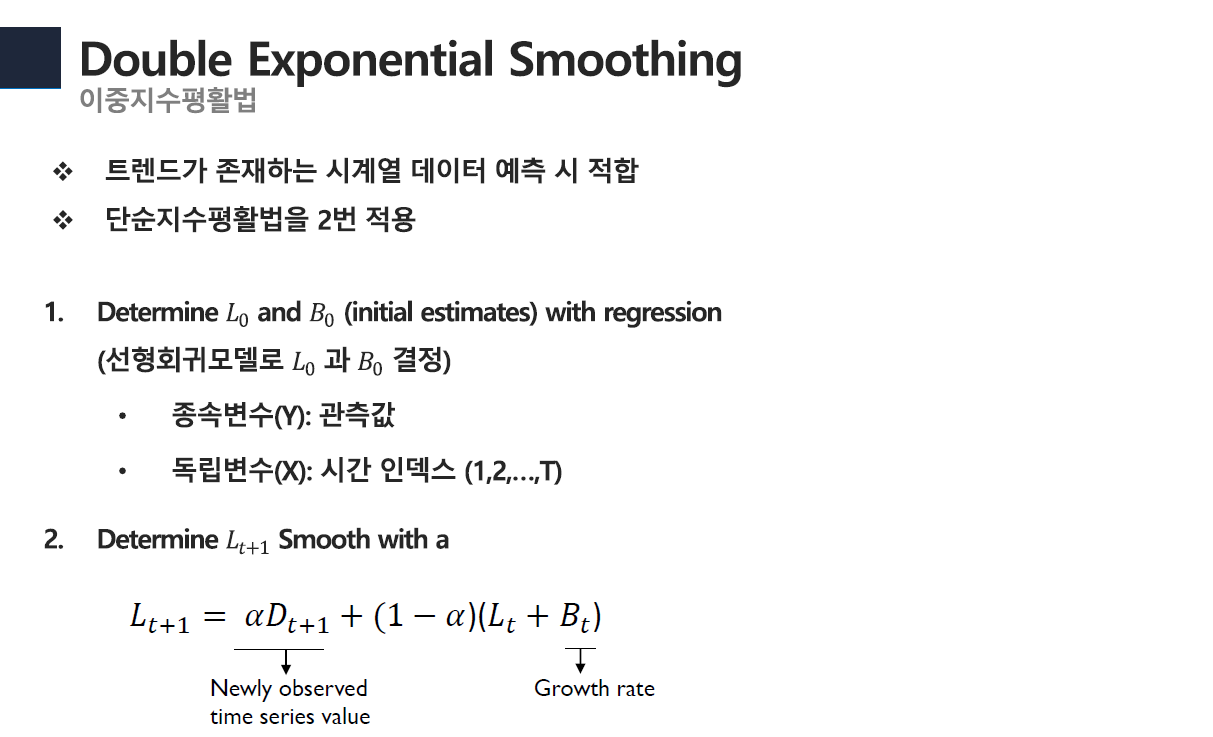

#### 4.3 Holt-Winter's Exponential Smoothing (홀트-윈터 지수평활법)

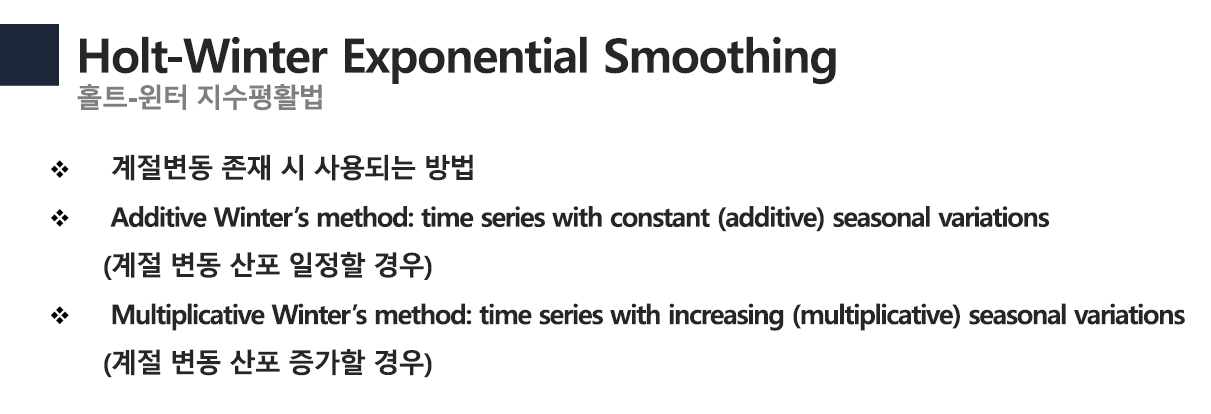

##### 4.3.1 Additive Winter's method

In [ ]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# HW_add_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(smoothing_level=alpha, smoothing_trend=gamma, smoothing_seasonal=delta)
HW_add_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(optimized=True)
HW_add_model.summary()

In [ ]:
HW_add_train_pred = HW_add_model.fittedvalues
HW_add_test_pred = HW_add_model.forecast(len(test))
HW_add_test_pred = pd.DataFrame(HW_add_test_pred, index=test.index, columns=['HW_add'])

print('Additive Holt-Winter Exponential Smoothing Train Results')
print(HW_add_train_pred)
print('-'*30)
print('Additive Holt-Winter Smoothing Test results')
print(HW_add_test_pred)

In [ ]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(HW_add_train_pred, columns=['HW_add'])
HW_add_pred = pd.concat([train_pred, HW_add_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
HW_add_pred.plot(ax=ax, label = 'Prediction (Additive)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'HW (Additive)', 'Start of Forecast'], loc='upper left')
plt.title('Holt-Winter Exponential Moving Average Results')
plt.tight_layout()
plt.show()

##### 4.3.2 Multiplicative Winter's method

In [ ]:
HW_mul_model = ExponentialSmoothing(train, trend='mul', seasonal='mul').fit(optimized=True)
HW_mul_model.summary()

In [ ]:
HW_mul_train_pred = HW_mul_model.fittedvalues
HW_mul_test_pred = HW_mul_model.forecast(len(test))
HW_mul_test_pred = pd.DataFrame(HW_mul_test_pred, index=test.index, columns=['HW_mul'])

print('Multiplicative Holt-Winter Exponential Smoothing Train Results')
print(HW_mul_train_pred)
print('-'*30)
print('Multiplicative Holt-Winter Smoothing Test results')
print(HW_mul_test_pred)

In [ ]:
'''
Visualization 
'''
# Train and Test
train_pred = pd.DataFrame(HW_mul_train_pred, columns=['HW_mul'])
HW_mul_pred = pd.concat([train_pred, HW_mul_test_pred])

fig, ax = plt.subplots(figsize=(12,4))
data.plot(ax=ax)
HW_mul_pred.plot(ax=ax, label = 'Prediction (Multiplicative)')
ax.vlines(test.index[0], 310, 370, linestyle='--', color='r')
ax.legend(['Raw Dataset', 'HW (Multiplicative)', 'Start of Forecast'], loc='upper left')
plt.title('Holt-Winter Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [ ]:
'''
Comparing
'''
fig, ax = plt.subplots(figsize=(12,4))
data['1990-01':].plot(ax=ax)
MA_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (N=5)')
SES_test_pred_09['1990-01':].plot(ax=ax, label = 'Prediction (alpha=0.9)')
DES_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (alpha=0.16, beta=0.1)')
HW_add_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (additive)')
HW_mul_test_pred['1990-01':].plot(ax=ax, label = 'Prediction (Multiplicative)')


ax.legend(['Raw Dataset', 'MA (N=5)', 'SES (alpha=0.9)', 'DES (alpha=0.16, beta=0.1)', 'HW (Additive)', 'HW (Multiplicative)'], loc='upper left')
plt.title('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [ ]:
'''
Quantitative Evaluation
'''
print('-'*55)
print('Moving Average (N = 5)')
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

print('-'*55)
print('Simple Exponential Smoothing (alpha = 0.9)')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_09), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_09)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_09), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_09), 2)}')

print('-'*55)
print('Double Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

print('-'*55)
print('Additive Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_add_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_add_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_add_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_add_test_pred), 2)}')

print('-'*55)
print('Multiplicative Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_mul_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_mul_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_mul_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_mul_test_pred), 2)}')

In [ ]:
test_predict_results = pd.concat([test, MA_test_pred, SES_test_pred_09, DES_test_pred, HW_add_test_pred, HW_mul_test_pred], axis=1)
test_predict_results

# EOD